### Examine the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df = pd.read_csv('waterTank_valueFlip_ctrl.csv', index_col=0, header=0, parse_dates=True)
df.index.freq = 'MS'

df.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [2]:
df.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [3]:
len(df)

15001

### Plot the source data

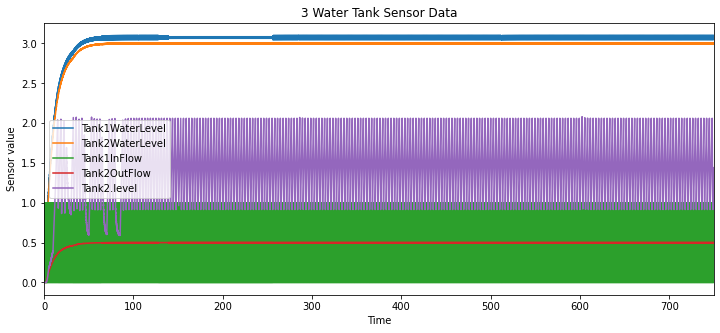

In [4]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Tank2WaterLevel'].plot(legend=True)
df['Tank1InFlow'].plot(legend=True)
df['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df['Tank2.level'].plot(legend=True)
plt.show()

In [5]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [6]:
adf_test(df['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [7]:
# All the correlated features are stationary.
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [8]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [9]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -59.96379197914196
BIC: -59.92929289014103

VAR Order 2
AIC: -64.3057412677667
BIC: -64.2410508142159

VAR Order 3
AIC: -68.06407292143241
BIC: -67.96918675138534

VAR Order 4
AIC: -71.15573827048534
BIC: -71.0306520309925

VAR Order 5
AIC: -72.67757262465737
BIC: -72.52228196176583

VAR Order 6
AIC: -73.82523232011505
BIC: -73.63973287886807

VAR Order 7
AIC: -74.81851904335586
BIC: -74.60280646779266

VAR Order 8
AIC: -75.17388379669684
BIC: -74.92795372985222

VAR Order 9
AIC: -75.64702265421768
BIC: -75.37087073812174

VAR Order 10
AIC: -77.30434927374046
BIC: -76.99797114941825

VAR Order 11
AIC: -77.66532378429409
BIC: -77.32871509176533

VAR Order 12
AIC: -78.46048812297516
BIC: -78.09364450125392

VAR Order 13
AIC: -78.71747929000182
BIC: -78.32039637709616

VAR Order 14
AIC: -79.34437519402148
BIC: -78.91704862693318

VAR Order 15
AIC: -79.73871952120422
BIC: -79.28114493592844

VAR Order 16
AIC: -80.4486193950382
BIC: -79.96079242656317

VAR Order 17
AIC: -80

In [10]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [11]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [12]:
min_aic_index

19

In [13]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, May, 2023
Time:                     12:37:15
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -81.7595
Nobs:                     11982.0    HQIC:                  -82.1440
Log likelihood:           375214.    FPE:                1.74184e-36
AIC:                     -82.3381    Det(Omega_mle):     1.61138e-36
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.017708         0.002205            8.030           0.000
L1.Tank1WaterLevel          0.329067         0.010414           31.600           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [14]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [15]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [16]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 3.09251765e+00,  3.00415650e+00, -1.74220464e-04,
         5.00301839e-01,  9.65273277e-01,  1.35546726e+00,
         9.64787129e-01],
       [ 3.06254777e+00,  3.00403440e+00, -3.89384377e-03,
         5.00993719e-01,  6.45689763e-03,  1.22454227e+00,
         9.19036146e-01],
       [ 3.04801213e+00,  2.99866385e+00,  9.49953921e-03,
         5.00276569e-01, -1.39059290e-02,  7.30194767e-03,
         9.36994769e-01],
       [ 3.07882929e+00,  2.99453390e+00,  1.00487635e+00,
         4.98964494e-01, -4.83226513e-03, -3.21754754e-02,
         9.67191707e-01],
       [ 3.09519531e+00,  2.99833765e+00,  9.95348624e-01,
         4.99271951e-01, -1.50039869e-02, -1.77625612e-02,
         9.88567212e-01],
       [ 3.08102099e+00,  3.00564230e+00, -1.36272147e-03,
         5.00792383e-01, -1.30001203e-02, -5.20233984e-02,
         1.02047820e+00],
       [ 3.06235813e+00,  3.00399501e+00,  4.29169506e-04,
         5.00988846e-01, -6.73295579e-03, -2.20240244e-02,
         1.0418325

In [17]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,3.092560,3.004144,0,0.500300,1,1.351439,0.964330
600.10,3.062618,3.004037,0,0.500995,0,1.282792,0.915346
600.15,3.047931,2.998697,0,0.500285,0,0.000000,0.931108
600.20,3.078778,2.994546,1,0.498971,0,0.000000,0.961127
600.25,3.095067,2.998294,1,0.499269,0,0.000000,0.981090
...,...,...,...,...,...,...,...
749.80,3.092561,3.004145,0,0.500300,0,0.000000,1.341046
749.85,3.071222,3.005454,0,0.501029,0,0.000000,1.361054
749.90,3.047931,2.998697,0,0.500285,0,0.000000,1.391114


In [18]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,3.092518,3.004156,-0.000174,0.500302,0.965273,1.355467,0.964787
1,3.062548,3.004034,-0.003894,0.500994,0.006457,1.224542,0.919036
2,3.048012,2.998664,0.009500,0.500277,-0.013906,0.007302,0.936995
3,3.078829,2.994534,1.004876,0.498964,-0.004832,-0.032175,0.967192
4,3.095195,2.998338,0.995349,0.499272,-0.015004,-0.017763,0.988567


### Plot the results

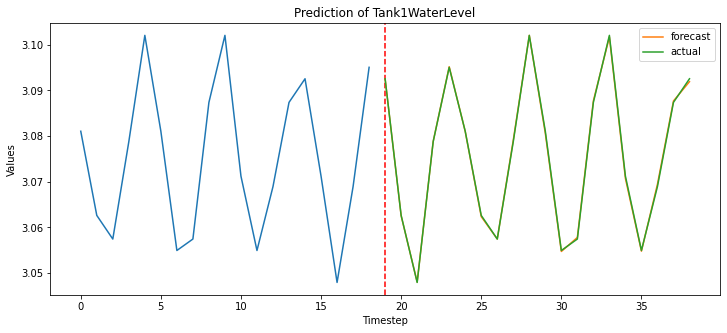

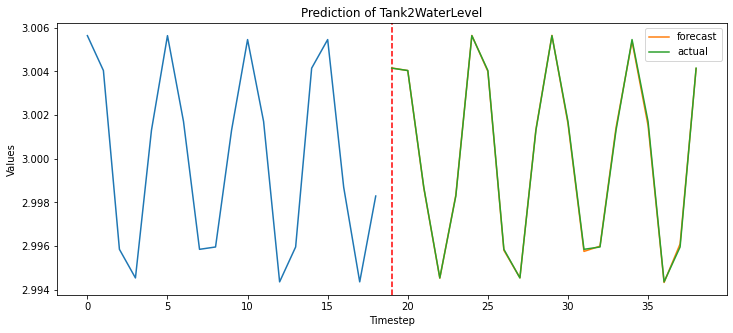

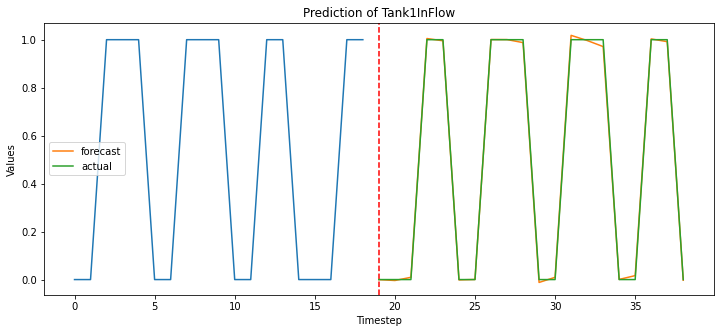

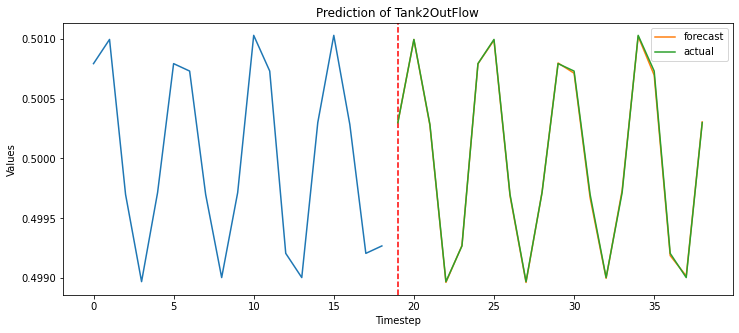

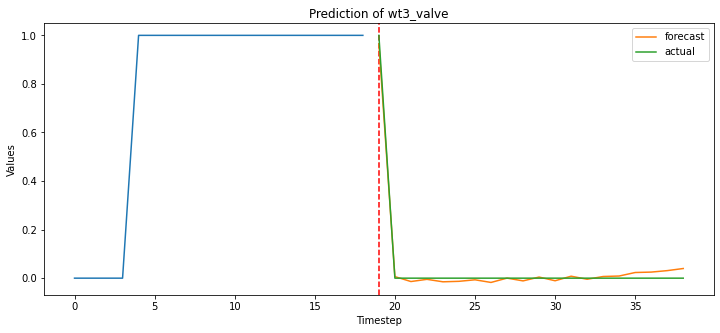

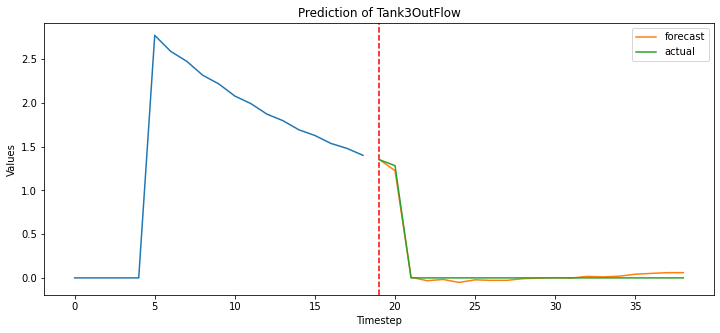

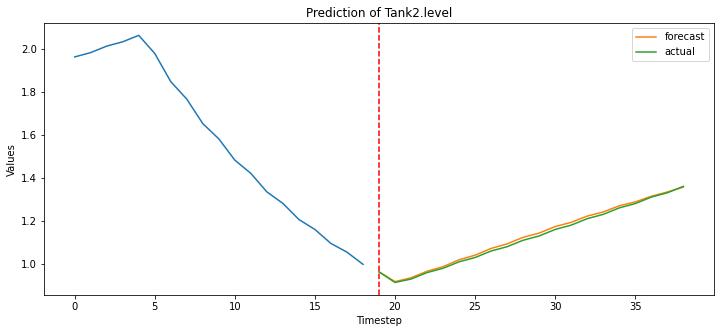

In [19]:
attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

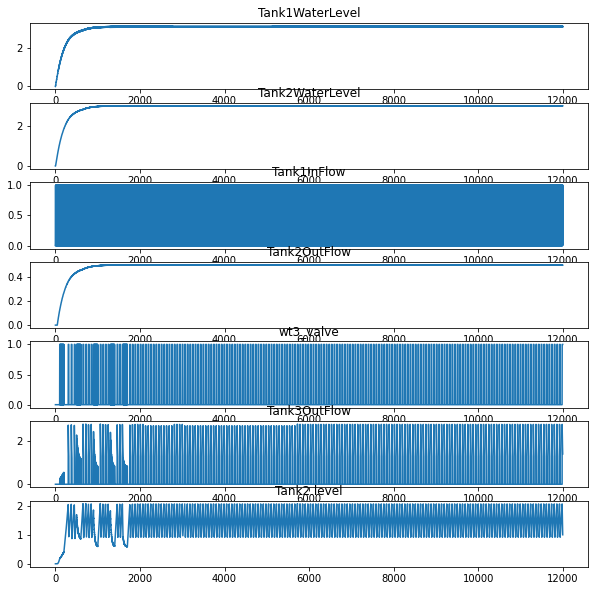

In [20]:
results.plot();

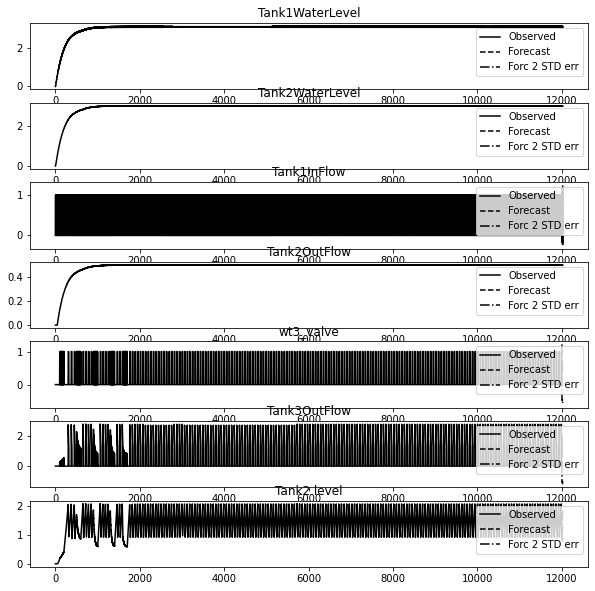

In [21]:
results.plot_forecast(20);

In [22]:
len(df_forecast)

20

In [23]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [24]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

print(RMSE) 

[2.9536256803265304, 2.9092481074774357, 0.7357667135751879, 0.5000057897660461, 0.216441576552137, 0.40959615176058906, 1.142117159248781]


### Save the model

In [25]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_valueFlip.pkl', 'wb') as f:
    pickle.dump(results.params, f)
print("Model saved!")

Model saved!


### Define the faulty data

In [26]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

### Load the model and reconstruct VAR

In [28]:
with open('var_ctrl_valueFlip.pkl', 'rb') as f:
    params = pickle.load(f)
    
valueFlip_model = sm.tsa.VAR(train)
valueFlip_model.params = params
valueFlip_model_fit = valueFlip_model.fit(min_aic_index)

valueFlip_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, May, 2023
Time:                     12:38:54
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -81.7595
Nobs:                     11982.0    HQIC:                  -82.1440
Log likelihood:           375214.    FPE:                1.74184e-36
AIC:                     -82.3381    Det(Omega_mle):     1.61138e-36
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.017708         0.002205            8.030           0.000
L1.Tank1WaterLevel          0.329067         0.010414           31.600           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [29]:
# Use the loaded model to make predictions or perform other analyses
forecast = valueFlip_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[ 3.09349394e+00,  3.00381962e+00, -1.64980743e-01,
         5.00231455e-01,  7.37644693e+00,  3.53402480e+00,
         2.60901112e+01],
       [ 3.06363671e+00,  3.00396106e+00, -1.95922614e-01,
         5.00956785e-01,  1.20316347e+01,  2.01946960e+01,
         2.51895118e+01],
       [ 3.04614327e+00,  2.99888470e+00, -2.53029675e-01,
         5.00287735e-01,  1.70054931e+01,  3.25111155e+01,
         2.36070669e+01],
       [ 3.07634760e+00,  2.99458867e+00,  7.81428907e-01,
         4.98946366e-01,  2.03077444e+01,  4.37698892e+01,
         2.14685778e+01],
       [ 3.09401119e+00,  2.99770779e+00,  9.75073687e-01,
         4.99125828e-01,  2.40375080e+01,  5.10784800e+01,
         1.89133620e+01],
       [ 3.08125151e+00,  3.00547263e+00, -2.18724896e-02,
         5.00693069e-01,  2.62813041e+01,  5.79535493e+01,
         1.60247293e+01],
       [ 3.06288416e+00,  3.00444408e+00, -7.64077495e-02,
         5.00971833e-01,  2.89728148e+01,  6.16193330e+01,
         1.2915216

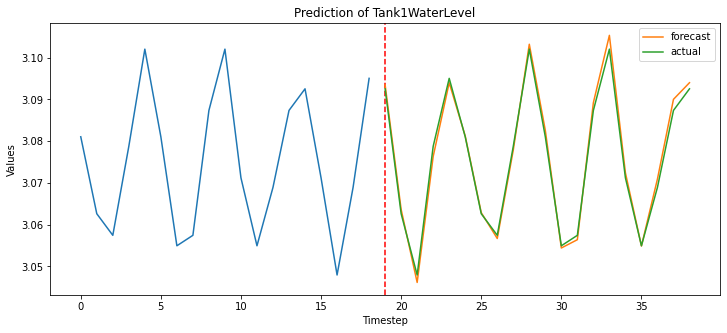

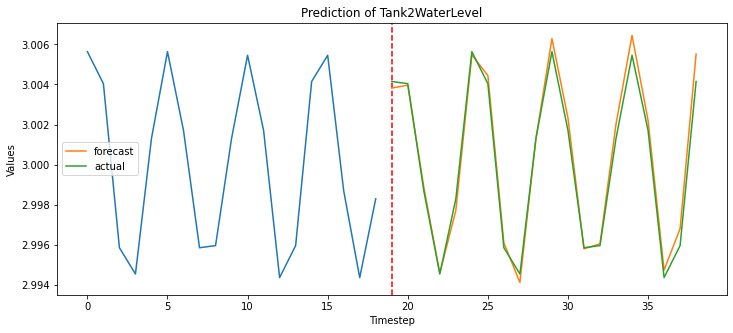

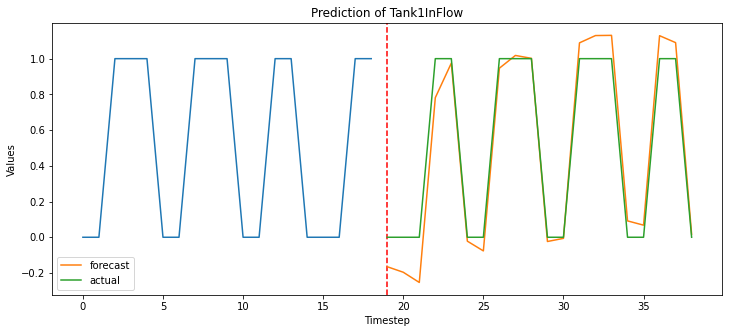

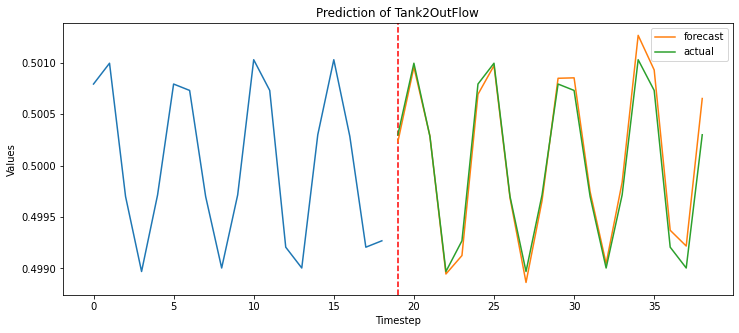

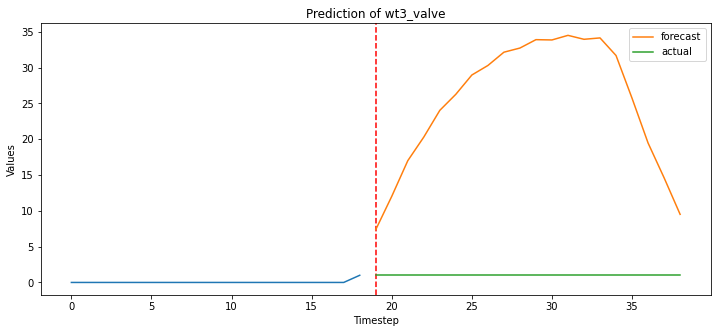

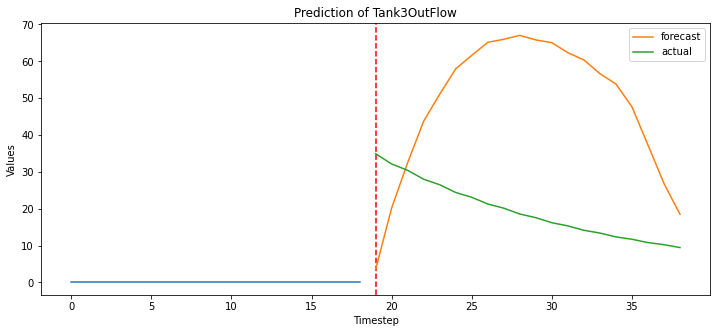

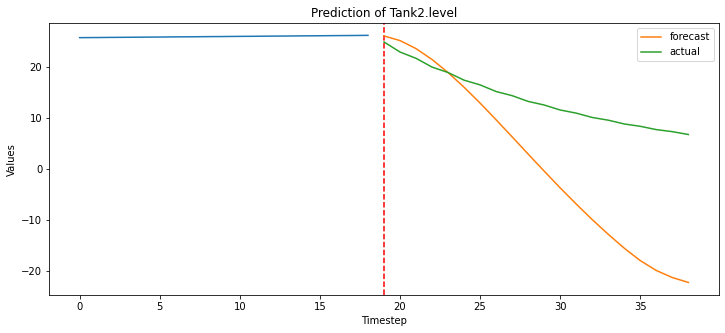

In [30]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [31]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[2.9540964017537346, 2.9095215099993794, 0.7855698909630335, 0.5000603530441285, 26.635344681408785, 51.56529513165309, 16.57429114818523]


In [32]:
print("Hayat")

Hayat
